In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import time

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv('AAPL_quarterly_financials.csv')

In [3]:
y.index = y.name

In [4]:
y = pd.DataFrame(y.loc['BasicEPS', :]).iloc[2:]

In [5]:
y.index = pd.to_datetime(y.index)

In [6]:
# check if NAs are no dividend period
# only drop Nas not 0.0
y = y.sort_index().fillna(0.)

# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [7]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ['Amazon', "Apple Watch", 'Tesla', 'AirPods', 'MacBook Air', 'Inflation rate', 'zebra', 'classroom', 'gun']  
# Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    time.sleep(5)
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [8]:
df = df.resample("Q").mean()

# 3.) Normalize all the X data

In [9]:
new_df = pd.concat([y,df], axis = 1).ffill().dropna()

In [10]:
X = new_df.iloc[:, 1:]

In [11]:
scaler = StandardScaler()

In [12]:
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled

,0,1,2,3,4,5,6,7,8
0,-1.503960,-0.860742,-0.888914,-0.635473,-1.545320,1.542017,-0.534122,-0.646264,0.718838
1,-1.503960,-0.860742,-0.901611,-0.635473,-1.545320,1.083503,-0.994785,-0.693108,-0.020358
2,-1.488635,-0.860742,-0.927004,-0.635473,-1.545320,0.395732,-1.493836,-0.669686,-0.361525
3,-1.258755,-0.860742,-0.914307,-0.635473,-1.545320,0.979295,-1.301893,-0.622843,-0.020358
4,-1.396683,-0.860742,-0.927004,-0.635473,-1.545320,1.104345,-1.148339,-0.646264,-0.475247
...,...,...,...,...,...,...,...,...,...
76,0.963412,1.458690,1.904324,1.756759,0.947466,2.688302,-0.418957,0.548240,0.946283
77,0.794834,1.310155,1.459945,1.393893,0.770253,1.938006,-0.841231,0.243759,-0.304664
78,0.917436,1.572948,1.802752,1.514848,1.301890,1.771274,-0.994785,0.126650,-0.702692
79,1.331219,1.858593,1.523428,1.891154,1.148306,1.917165,-1.301893,0.431132,0.093365


In [13]:
y = pd.DataFrame(new_df.iloc[:, 0])
y

,BasicEPS
2004-03-31,0.002
2004-06-30,0.003
2004-09-30,0.0
2004-12-31,0.013
2005-03-31,0.013
...,...
2023-03-31,1.53
2023-06-30,1.27
2023-09-30,1.47
2023-12-31,1.47


# 4.) Run a Lasso with lambda of .06. Plot a bar chart.

In [14]:
lasso = Lasso(alpha=0.06)

In [15]:
lasso.fit(X_scaled, y)

Lasso(alpha=0.06)

In [16]:
coefficients = lasso.coef_

In [17]:
coefficients

array([ 0.08432498,  0.24371857,  0.00830121,  0.05428143,  0.06123648,
        0.02832993,  0.        , -0.        ,  0.        ])

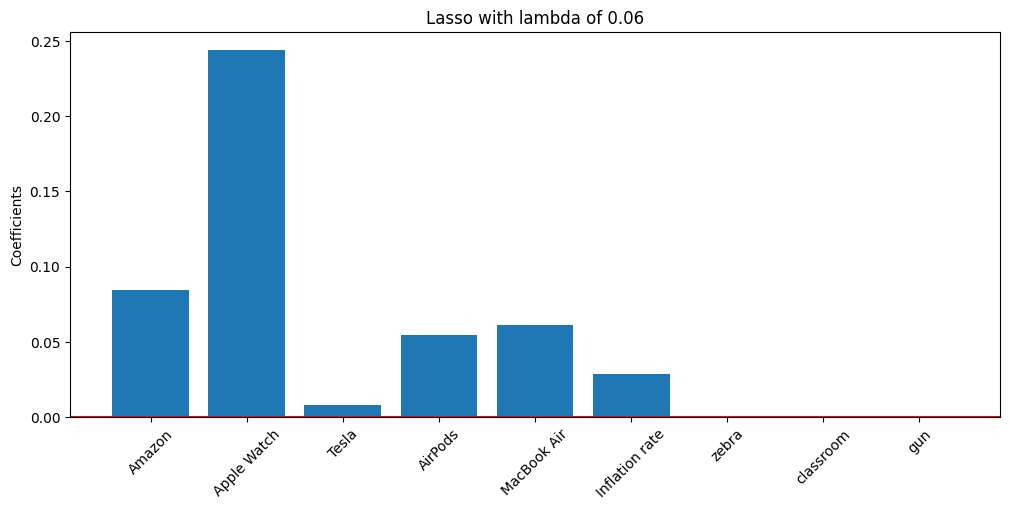

In [18]:
# label graph
plt.figure(figsize = (12, 5))
plt.bar(range(len(coefficients)), coefficients)
plt.axhline(0, color = 'red')
plt.title('Lasso with lambda of 0.06')
plt.ylabel('Coefficients')
plt.xticks(range(len(keywords)), keywords, rotation=45)
plt.show()

# 5.) Do these coefficient magnitudes make sense?

Yes.

The graph of the Lasso regression coefficients makes sense, considering that the first six terms—'Amazon', 'Apple Watch', 'Tesla', 'AirPods', 'MacBook Air', and 'Inflation rate'—could reasonably be thought to nowcast Apple's earnings, either through direct association with Apple's products or through economic indicators relevant to consumer spending and pricing strategies. In contrast, the last three terms—'zebra', 'classroom', and 'gun'—are intuitively unrelated to Apple's business and, as expected, do not appear to have a significant forecasting ability for Apple's earnings, reflected by their minimal or zero coefficients.

Apple Watch: The large positive coefficient for "Apple Watch" suggests that this keyword has a strong positive association with Apple's EPS. It might indicate that "Apple Watch" as a feature is particularly relevant or influential in predicting the EPS, perhaps due to its sales or market significance being highly correlated with the financial performance of Apple.

Other (Amazon, Tesla, AirPods, MacBook Air): Smaller positive coefficients for these products imply a positive relationship with Apple's EPS, but not as strong as that for the "Apple Watch." This might reflect a scenario where these products contribute positively to Apple's EPS but are not as significant predictors as the "Apple Watch" in the model.

The positive coefficient for "Inflation rate" in predicting Apple's EPS may suggest that Apple has the ability to pass on higher costs to consumers without significantly reducing demand, thereby maintaining or increasing its profit margins in inflationary periods. Additionally, it could indicate that during times of inflation, nominal revenue growth, coupled with Apple's strong market position, leads to a rise in EPS despite the broader economic impact of inflation.

Non-Apple Related Keywords (Zebra, Classroom, Gun): The fact that these coefficients are potentially zero suggests that these features have no association with Apple's EPS, according to the model. It makes sense if these keywords are not directly related to Apple's business performance.

In conclusion, assuming that the model has been validated for its predictive power and the features were appropriately scaled, the coefficients appear to make sense, with product-related features showing positive associations with Apple's EPS and unrelated keywords showing no association.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?